In [23]:
import httpimport
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn

from utils import ILSVRC2014Sample, to_np, to_tensor, CUDA, VGG

with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    import common.plotting

In [2]:
vgg = VGG("vgg19")
if CUDA:
    vgg.cuda()

In [3]:
# List layers in the model
print("Feature layers")
print("--------------")
for name, layer in zip(vgg.feature_names, vgg.features):
    print("{1: <12} {0: <8}  ({2}".format(name, *str(layer).split("(", 1)))
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace=True)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace=True)
MaxPool2d    pool1     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace=True)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace=True)
MaxPool2d    pool2     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace=True)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace=True)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride

In [5]:
class SubsampledImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indexes, transform, **kwargs):
        super(SubsampledImageDataset, self).__init__(**kwargs)
        self.dataset = dataset
        self.indexes = indexes
        self.transform = transform

    def __getitem__(self, i):
        img, label = self.dataset[self.indexes[i]]
        img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.indexes)

In [9]:
#![ -d 101_ObjectCategories.tar.gz ] || gdown https://drive.google.com/u/0/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
![ -e ../data/101_ObjectCategories.tar.gz ] || gdown https://drive.google.com/u/0/uc?id=10NIeg2v6b9SzBBkqzbxUT_xTTgzIjsmv -O ../data/101_ObjectCategories.tar.gz
![ -d ../data/101_ObjectCategories ] || tar zxf ../data/101_ObjectCategories.tar.gz -C ../data

In [12]:
caltech_whole_dataset = torchvision.datasets.ImageFolder("../data/101_ObjectCategories/")

all_indexes = np.random.permutation(len(caltech_whole_dataset))
train_size = int(len(all_indexes) * 0.8)

caltech_train_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[:train_size],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomResizedCrop(224),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
        ]
    ),
)

caltech_test_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[train_size:],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
        ]
    ),
)

caltech_datasets = {
    "train": caltech_train_dataset,
    "test": caltech_test_dataset,
}

In [13]:
batch_size = 64

caltech_loaders = {
    "train": torch.utils.data.DataLoader(
        caltech_datasets["train"], batch_size=batch_size, num_workers=4, shuffle=True
    ),
    "test": torch.utils.data.DataLoader(
        caltech_datasets["test"], batch_size=batch_size, num_workers=4, shuffle=False
    ),
}

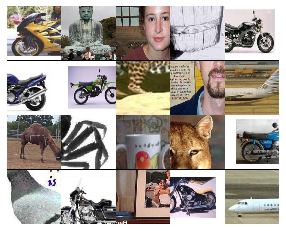

In [15]:
train_batch = next(iter(caltech_loaders["train"]))
common.plotting.plot_mat(to_np(train_batch[0])[:20])

In [16]:
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))


Classifier layers
-----------------
Linear      (in_features=25088, out_features=4096, bias=True)
ReLU        (inplace=True)
Dropout     (p=0.5, inplace=False)
Linear      (in_features=4096, out_features=4096, bias=True)
ReLU        (inplace=True)
Dropout     (p=0.5, inplace=False)
Linear      (in_features=4096, out_features=1000, bias=True)


In [18]:
# Train only the classifier!
def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()

        with torch.no_grad():
            outputs = model.forward(x)
            _, predictions = outputs.max(dim=1)
            num_errs += (predictions != y).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples


def train(
    model, data_loaders, optimizer, criterion, num_epochs=1, log_every=100, cuda=True
):
    if cuda:
        model.cuda()

    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("You can interrupt it at any time.")
    try:
        while epoch < num_epochs:
            model.train()
            # model.train_mode()
            epoch += 1
            for x, y in data_loaders["train"]:
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1

                optimizer.zero_grad()
                out = model.forward(x)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y).sum() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(err_rate.item())

                                
                if iter_ % log_every == 0:
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%".format(
                            iter_, loss.item(), err_rate
                        )
                    )

            val_err_rate = compute_error_rate(model, data_loaders["test"], cuda)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:

                                
                best_epoch = epoch
                best_val_err = val_err_rate

                
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        model.parameters = best_params
    plot_history(history)


def plot_history(history):
    plt.figure(figsize=(16,4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    plt.ylim(0, 20)
    plt.legend()

Training the model!
You can interrupt it at any time.
Minibatch     50  | loss  1.61 | err rate 37.50%
Minibatch    100  | loss  1.27 | err rate 29.69%
----------------------------------------------------------
After epoch  1 | valid err rate: 15.80% | doing  10 epochs
----------------------------------------------------------
Minibatch    150  | loss  0.80 | err rate 14.06%
Minibatch    200  | loss  0.71 | err rate 18.75%
----------------------------------------------------------
After epoch  2 | valid err rate: 12.03% | doing  10 epochs
----------------------------------------------------------
Minibatch    250  | loss  1.00 | err rate 25.00%
Minibatch    300  | loss  0.53 | err rate 10.94%
----------------------------------------------------------
After epoch  3 | valid err rate: 11.10% | doing  10 epochs
----------------------------------------------------------
Minibatch    350  | loss  0.44 | err rate 10.94%
Minibatch    400  | loss  0.82 | err rate 18.75%
Minibatch    450  | los

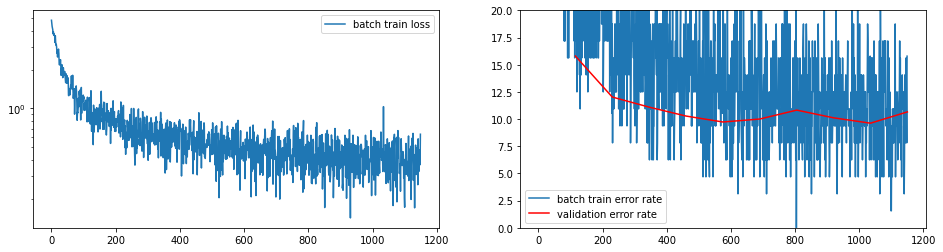

In [25]:
# TODO: implement a new classifier using `torch.nn.Sequential` and `torch.nn.Linear`
classifier = nn.Sequential(nn.Linear(25088, 102))

# Replace the classifier of our VGG network
vgg.classifier = classifier

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.classifier.parameters():
    p.requires_grad = True

criterion = (
    nn.CrossEntropyLoss()
)  # Note: nn.CrossEntropyLoss combines LogSoftmax with NLLLoss

# Train only the params of the classifier
optimizer = torch.optim.Adam(vgg.classifier.parameters(), lr=0.0001)

train(
    vgg, caltech_loaders, optimizer, criterion, num_epochs=10, log_every=50, cuda=True
)